# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In [180]:
import pickle
import pandas as pd
import numpy as np
from numpy import zeros, newaxis
import cv2
import csv
import glob
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [181]:
#Helper functions
def loadData():
    # Load pickled data
    #The pickled data is a dictionary with 4 key/value pairs:
    #'features' is a 4D array containing raw pixel data of the traffic sign images, 
    #(num examples, width, height, channels).
    #'labels' is a 1D array containing the label/class id of the traffic sign. 
    #The file signnames.csv contains id -> name mappings for each id.
    #'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
    #'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 
    #THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES

    training_file = "traffic-signs-data/train.p"
    validation_file= "traffic-signs-data/valid.p"
    testing_file = "traffic-signs-data/test.p"
    sign_classes = pd.read_csv('signnames.csv', sep=",")
    #data.columns = ["ClassId", "SignName"]
    sign_classes = sign_classes.values

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train, train_image_size, train_image_coords = train['features'], train['labels'], train['sizes'],train['coords'] 
    X_valid, y_valid, valid_image_size, valid_image_coords = valid['features'], valid['labels'], valid['sizes'], valid['coords'] 
    X_test, y_test, test_image_size, test_image_coords = test['features'], test['labels'], test['sizes'], test['coords'] 

    assert(len(X_train) == len(y_train))
    assert(len(X_valid) == len(y_valid))
    assert(len(X_test) == len(y_test))
    # Concantenate the Train and Vald data sets including the labels
    X_train = np.concatenate((X_train, X_valid), axis=0)
    y_train = np.concatenate((y_train, y_valid), axis=0)
    
    X_train, y_train = shuffle(X_train, y_train)
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.2, random_state=0)
    
    print("Training Set:   {} samples {} shape".format(len(X_train), X_train.shape))
    print("Validation Set: {} samples {} shape".format(len(X_valid), X_valid.shape))
    print("Test Set:       {} samples {} shape".format(len(X_test), X_test.shape))
    print("Sign Classes Label: {} samples".format(sign_classes.shape[0]))
    print()
    print("Image Shape: {}".format(X_train[0].shape))
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test, sign_classes

# Problem 1 - Implement Min-Max scaling for grayscale image data
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image data
    a=0.1
    b=0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

### DON'T MODIFY ANYTHING BELOW ###
# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])


def one_hot_encode(is_labels_encod, train_labels, valid_labels, test_labels):
    if not is_labels_encod:
        # Turn labels into numbers and apply One-Hot Encoding
        encoder = LabelBinarizer()
        encoder.fit(train_labels)
        train_labels = encoder.transform(y_train)
        valid_labels = encoder.transform(y_valid)
        test_labels = encoder.transform(y_test)

        # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
        train_labels = train_labels.astype(np.float32)
        valid_labels  = test_labels.astype(np.float32)
        test_labels = test_labels.astype(np.float32)
        is_labels_encod = True
        print('Labels One-Hot Encoded')
        return train_labels, valid_labels, test_labels

def normalize_features(is_features_normal, train_data, valid_data, test_data):
    if not is_features_normal:
        train = normalize_grayscale(train_data)
        valid = normalize_grayscale(valid_data)
        test = normalize_grayscale(test_data)
        is_features_normal = True
        print('Features Normalized')
        return train, valid, test
    
def convert_rgb2gray(rgb_train_data, rgb_valid_data, rgb_test_data):
    X_train_grey= color.rgb2gray(rgb_train_data[:])
    X_train_grey = X_train_grey[..., newaxis] # add the new axis which is the channel
    X_valid_grey= color.rgb2gray(rgb_valid_data[:])
    X_valid_grey = X_valid_grey[..., newaxis] # add the new axis which is the channel
    X_test_grey= color.rgb2gray(rgb_test_data[:])
    X_test_grey = X_test_grey[..., newaxis] # add the new axis which is the channel    
    print("Training Set:   {} samples {} shape".format(len(X_train_grey), X_train_grey.shape))
    print("Validation Set: {} samples {} shape".format(len(X_valid_grey), X_valid_grey.shape))
    print("Test Set:       {} samples {} shape".format(len(X_test_grey), X_test_grey.shape))
    print()
    print("Image Shape: {}".format(X_train_grey[0].shape))
    print("Sign Classes Label: {} samples".format(sign_classes.shape[0]))#unique classes/labels there are in the dataset
    
    return X_train_grey, X_valid_grey, X_test_grey  
    
    
def dataset_sign_counts(train_labels, valid_labels, test_labels):
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    plt.bar(unique_train, counts_train)
    plt.grid()
    plt.title("Train Dataset Sign Counts")
    plt.show()

    unique_test, counts_test = np.unique(y_test, return_counts=True)
    plt.bar(unique_test, counts_test)
    plt.grid()
    plt.title("Test Dataset Sign Counts")
    plt.show()

    unique_valid, counts_valid = np.unique(y_valid, return_counts=True)
    plt.bar(unique_valid, counts_valid)
    plt.grid()
    plt.title("Valid Dataset Sign Counts")
    plt.show()

def plot_gallery_color(images, classes, h, w, d, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    max_range = min(len(images), n_row*n_col)
    #for i in range(n_row * n_col):
    for i in range(0, max_range):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, d)), cmap=plt.cm.gray)
        plt.title(classes[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()
    
def plot_gallery_grey(images, classes, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    max_range = min(len(images), n_row*n_col)
    #for i in range(n_row * n_col):
    for i in range(0, max_range):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(classes[i], size=12)
        #plt.title(name_values[my_labels[classes[i]]][1].decode('ascii'), size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

#Some useful image functions
  
def show2img(img, img1):
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Raw image")
    plt.subplot(1, 3, 2)
    plt.imshow(img1)
    plt.title("Processed image")
    plt.show()
    
def eq_Hist(img):
    #Histogram Equalization
    img2=img.copy() 
    img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img2

def scale_img(img):
    img2=img.copy()
    sc_y=0.4*np.random.rand()+1.0
    img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
    c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
    return img2

def crop(img, mar=0):
    c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
    return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
    c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
    ang = 30.0*np.random.rand()-15
    Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
    return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)

def transform_img(img):
    img2=sharpen_img(img)
    #img2=crop(img2,3)
    img2=contr_img(img2, 1.5)
    return img2
    #return eq_Hist(img2)

def augment_img(img):
    img=contr_img(img, 1.8*np.random.rand()+0.2)
    img=rotate_img(img)
    img=scale_img(img)
    return transform_img(img)

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

Training Set:   31367 samples (31367, 32, 32, 3) shape
Validation Set: 7842 samples (7842, 32, 32, 3) shape
Test Set:       12630 samples (12630, 32, 32, 3) shape
Sign Classes Label: 43 samples

Image Shape: (32, 32, 3)


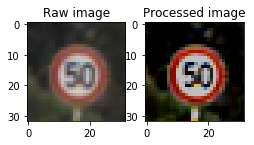

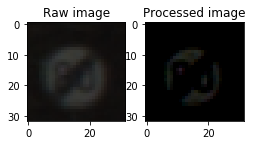

Total number of images in the augmented dataset =  31367
Total number of images in the augmented dataset =  7842
Total number of images in the train dataset =  62734
Total number of images in the valid dataset =  15684
Features Normalized
Labels One-Hot Encoded
Training Set:   62734 samples (62734, 32, 32, 1) shape
Validation Set: 15684 samples (15684, 32, 32, 1) shape
Test Set:       12630 samples (12630, 32, 32, 1) shape

Image Shape: (32, 32, 1)
Sign Classes Label: 43 samples


In [182]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data
# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

#name_values = np.genfromtxt('signnames.csv', skip_header=1, dtype=[('myint','i8'), ('mysring','S55')], delimiter=',')
#Import traffic signs class names
signs_class=[]
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        signs_class.append((row['SignName']))

X_train, y_train, X_valid, y_valid, X_test, y_test, sign_classes = loadData()

img_size=X_train.shape[1] #Size of input images


im=X_train[1]
show2img(im, transform_img(im))

im=X_train[2]
show2img(im, transform_img(im))


X_train_aug = []
y_train_aug = []
X_valid_aug = []
y_valid_aug = []

for i in range(len(X_train)):
        img=X_train[i]
        X_train_aug.append(transform_img(img))
        y_train_aug.append(y_train[i])
print("Total number of images in the augmented dataset = ", len(X_train_aug))

for i in range(len(X_valid)):
        img=X_valid[i]
        X_valid_aug.append(transform_img(img))
        y_valid_aug.append(y_valid[i])
print("Total number of images in the augmented dataset = ", len(X_valid_aug))


# Concantenate the Train and Vald data sets including the labels
X_train = np.concatenate((X_train, X_train_aug), axis=0)
y_train = np.concatenate((y_train, y_train_aug), axis=0)
print("Total number of images in the train dataset = ", len(X_train))

X_valid = np.concatenate((X_valid, X_valid_aug), axis=0)
y_valid = np.concatenate((y_valid, y_valid_aug), axis=0)
print("Total number of images in the valid dataset = ", len(X_valid))

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)


### Other preprocessing steps could include converting to grayscale, etc.
X_train, X_valid, X_test = normalize_features(is_features_normal, X_train, X_valid, X_test)

y_train_label, y_valid_label, y_test_label = one_hot_encode(is_labels_encod, y_train, y_valid, y_test)
      
X_train_grey, X_valid_grey, X_test_grey = convert_rgb2gray(X_train, X_valid, X_test)


### Include an exploratory visualization of the dataset

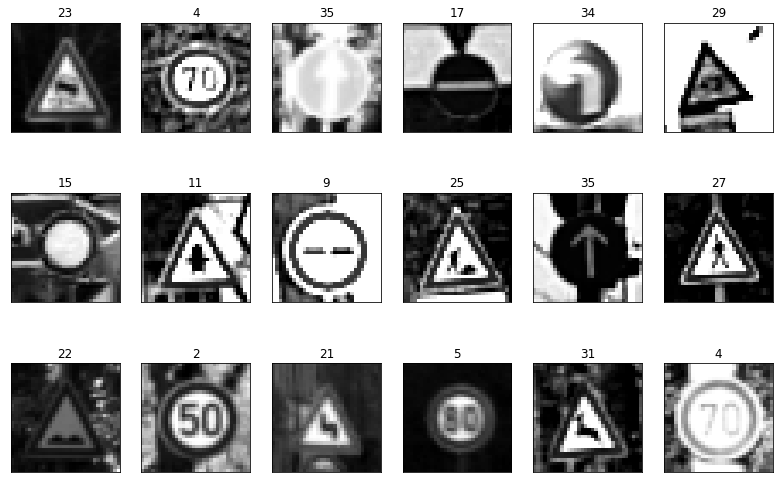

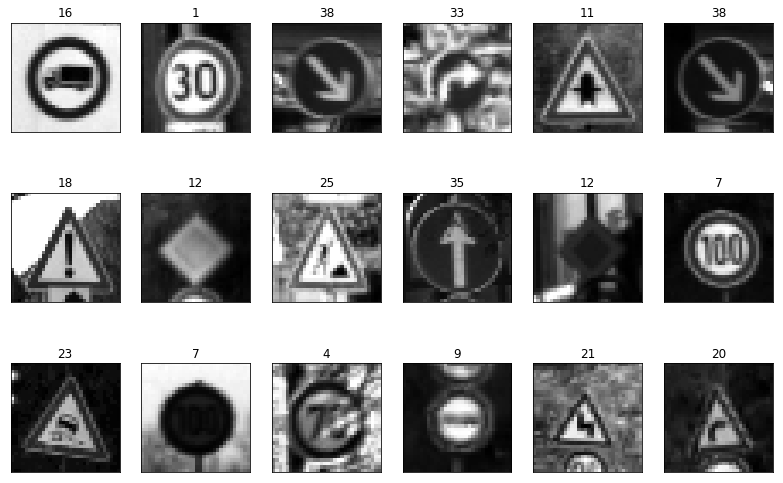

test


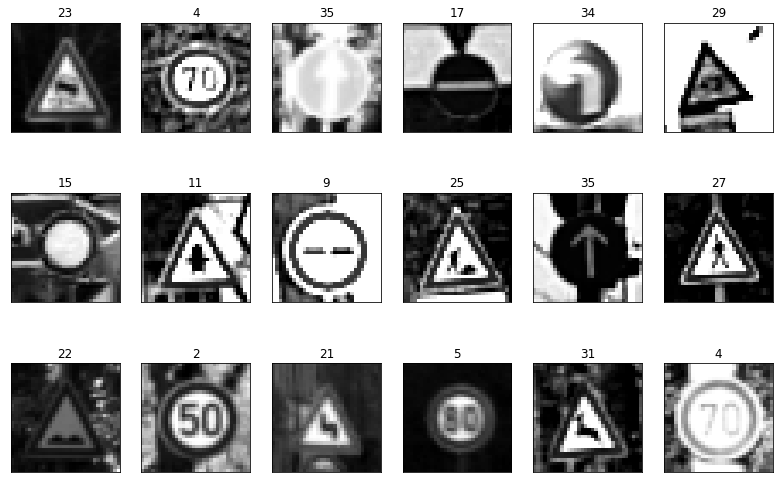

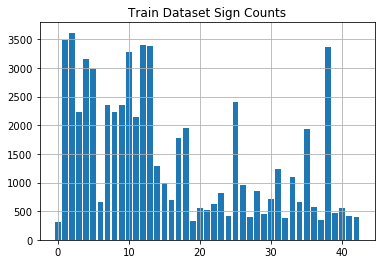

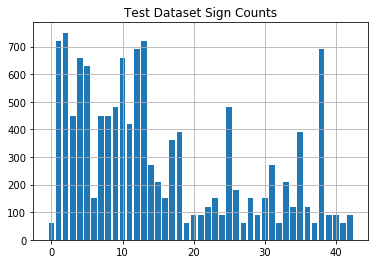

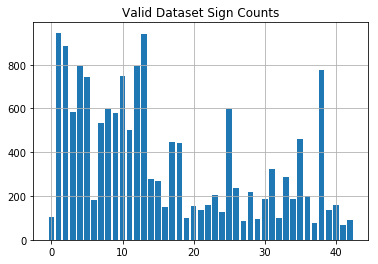

In [183]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# Visualizations will be shown in the notebook.
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib
h, w, d = X_train_grey[0].shape[0], X_train_grey[1].shape[1], 0

plot_gallery_grey(X_train_grey, y_train, h, w)
plot_gallery_grey(X_test_grey, y_test, h, w)
print('test')
plot_gallery_grey(X_train_grey, y_train, h, w)

dataset_sign_counts(y_train, y_valid, y_test)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Model Architecture

In [184]:
from tensorflow.contrib.layers import flatten

#Network Parameters
n_classes = 43 # MNIST total classes (0-9 digits)
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    print('Input conv shape {}'.format(x.shape))
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    print('Output conv shape {}'.format(x.shape))
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
    padding='SAME')

def fullyConnected(x, W, b, dropout =1, keepProb=1):
    x   = tf.matmul(x, W) + b
    x   = tf.nn.relu(x)
    #During training, a good starting value for keep_prob is 0.5.
    #During testing, use a keep_prob value of 1.0 to keep all units 
    #and maximize the power of the model.
    if dropout ==1:
        return tf.nn.dropout(x, keep_prob)
    else: 
        return x
    
weights = {
    'conv1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma)),
    'conv2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
    'conv3': tf.Variable(tf.truncated_normal(shape=(4, 4, 16, 412), mean = mu, stddev = sigma)),
    'fc1': tf.Variable(tf.truncated_normal(shape=(412, 122), mean = mu, stddev = sigma)),
    'fc2': tf.Variable(tf.truncated_normal(shape=(122, 84), mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))}

biases = {
    'conv1': tf.Variable(tf.zeros([6])),
    'conv2': tf.Variable(tf.zeros([16])),
    'conv3': tf.Variable(tf.zeros([412])),
    'fc1': tf.Variable(tf.zeros([122])),
    'fc2': tf.Variable(tf.zeros([84])),
    'out': tf.Variable(tf.zeros([n_classes]))}

def build_model(x):
    logits, layer1, layer2, layer3, layer4, layer5 = LeNet(x)
    return logits

def LeNet(x):    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    #In TensorFlow, strides is an array of 4 elements; the first element in this array indicates 
    #the stride for batch and last element indicates stride for features. It's good practice 
    #to remove the batches or features you want to skip from the data set rather than use a 
    #stride to skip them. You can always set the first and last element to 1 in strides in order 
    #to use all batches and features.
    #In Layer1 I want to transform the input shape (?, 32, 32, 1) to (?, 28, 28, 6)
    # so need to calculate the shape and strides
    #out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
    #out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
    #SHAPE
    #out_height = ceil(float(32 - 5 + 1) / float(strides[1])) = ceil(28/1) = 28
    #out_width  = ceil(float(32 - 5 + 1) / float(strides[2])) = ceil(28/1) = 28
    #input depth = 1
    #output depth = 6
    #STRIDES = [?,1,1,?]
    conv1 = conv2d(x, weights['conv1'], biases['conv1'])
    layer1 = conv1
    print('Layer 1 conv1 shape {}'.format(conv1.shape))
   
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)
    print('Layer 1 Max Pool shape {}'.format(conv1.shape))
    
    #Layer 2: Convolutional. Input = 14*14*6. Output = 10x10x16.
    #SHAPE
    #out_height = ceil(float(28 - 5 + 1) / float(strides[1])) = ceil(10/1) = 14
    #out_width  = ceil(float(28 - 5 + 1) / float(strides[2])) = ceil(10/1) = 14
    #input depth = 6
    #output depth = 16
    #STRIDES = [?,1,1,?]
    conv2 = conv2d(conv1, weights['conv2'], biases['conv2'])
    layer2 = conv2
    print('Layer 2 conv2 shape {}'.format(conv2.shape))

    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)
    print('Layer 2 Max Pool shape {}'.format(conv2.shape))
    
    # Layer 3: Convolutional Transform the input shape (5, 5, 16) to (2, 2, 412)
    #SHAPE
    #out_height 5 = ceil(float(5 - 4 + 1) / float(strides[1])) = ceil(10/1) = 2
    #out_width  5 = ceil(float(5 - 4 + 1) / float(strides[2])) = ceil(10/1) = 2
    #input depth = 16
    #output depth = 412
    #STRIDES = [?,1,1,?]
    conv3   = conv2d(conv2, weights['conv3'], biases['conv3'])
    layer3 = conv3
    #conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    print('Layer 3 conv3 shape {}'.format(conv3.shape))
    
    #Pooling. Input = 2 x 2 x 412. Output = 1 x 1 x 412.
    conv3 = maxpool2d(conv3)
    print('Layer 3 Max Pool shape {}'.format(conv3.shape))
    
    # Flatten. Input = 1x1x412. Output = 412,
    fc0   = flatten(conv3)
    print('Flatten Shape {}'.format(fc0.shape))
    
    #Layer 4: Fully Connected. Input = 412  Output = 122
    fc1 = fullyConnected(fc0, weights['fc1'], biases['fc1'])
    print('Layer 4 FC Shape {}'.format(fc1.shape))
    
    #Note: During training, a good starting value for keep_prob is 0.5.
    #During testing, use a keep_prob value of 1.0 to keep all units 
    #and maximize the power of the model.
    
    fc2 = fullyConnected(fc1, weights['fc2'], biases['fc2'])
    print('Layer 5 FC Shape {}'.format(fc2.shape))

    #Layer 6: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    print('FC Layer6 Shape {}'.format(logits.shape))
    
    return logits, layer1, layer2, layer3, fc1, fc2

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Input conv shape (?, 32, 32, 1)
Output conv shape (?, 28, 28, 6)
Layer 1 conv1 shape (?, 28, 28, 6)
Layer 1 Max Pool shape (?, 14, 14, 6)
Input conv shape (?, 14, 14, 6)
Output conv shape (?, 10, 10, 16)
Layer 2 conv2 shape (?, 10, 10, 16)
Layer 2 Max Pool shape (?, 5, 5, 16)
Input conv shape (?, 5, 5, 16)
Output conv shape (?, 2, 2, 412)
Layer 3 conv3 shape (?, 2, 2, 412)
Layer 3 Max Pool shape (?, 1, 1, 412)
Flatten Shape (?, 412)
Layer 4 FC Shape (?, 122)
Layer 5 FC Shape (?, 84)
FC Layer6 Shape (?, 43)
num_examples 62734
Training...
EPOCH 1 ...
Train Accuracy = 70.7%
Validation Accuracy = 69.1%

EPOCH 2 ...
Train Accuracy = 84.7%
Validation Accuracy = 83.5%

EPOCH 3 ...
Train Accuracy = 90.1%
Validation Accuracy = 89.2%

EPOCH 4 ...
Train Accuracy = 91.7%
Validation Accuracy = 90.5%

EPOCH 5 ...
Train Accuracy = 94.3%
Validation Accuracy = 93.3%

EPOCH 6 ...
Train Accuracy = 94.8%
Validation Accuracy = 93.7%

EPOCH 7 ...
Train Accuracy = 95.2%
Validation Accuracy = 94.2%

EPOCH 8 .

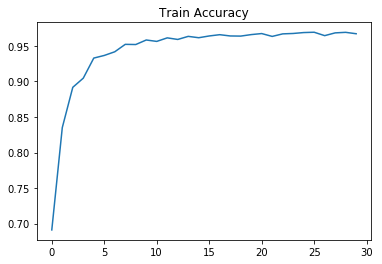

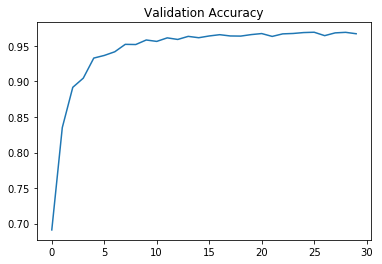

In [185]:
### x is a placeholder for a batch of input images. 
### y is a placeholder for a batch of output labels.
EPOCHS = 30
BATCH_SIZE = 156
rate = 0.00097
##tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)
### Train your model here.

validation_accuracy_progress = []
train_accuracy_progress = []
test_accuracy_progress = []

logits = build_model(x)
# Define loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples
### Calculate and report the accuracy on the training and validation set.

with tf.Session() as sess:
    #saver.restore(sess, './lenet')
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_grey)
    print('num_examples {}'.format(num_examples))
    print("Training...")
    for i in range(EPOCHS):
        X_train_grey, y_train = shuffle(X_train_grey, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            #print('num_examples {} Batch Size {} end {}'.format(num_examples, BATCH_SIZE, end))
            batch_x, batch_y = X_train_grey[offset:end], y_train[offset:end]
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
   
        validation_accuracy = evaluate(X_valid_grey, y_valid)
        validation_accuracy_progress.append(validation_accuracy)
        
        train_accuracy = evaluate(X_train_grey, y_train)
        train_accuracy_progress.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.1%}".format(train_accuracy))
        print("Validation Accuracy = {:.1%}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#   saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test_grey, y_test)
    test_accuracy_progress.append(test_accuracy)
    print("Test Data Set Accuracy = {:.1%}".format(test_accuracy))

plt.plot(train_accuracy_progress)
plt.title("Train Accuracy")
plt.show()

plt.plot(validation_accuracy_progress)
plt.title("Validation Accuracy")
plt.show()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

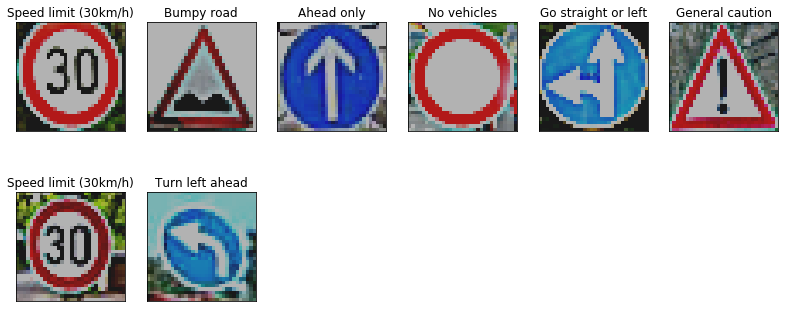

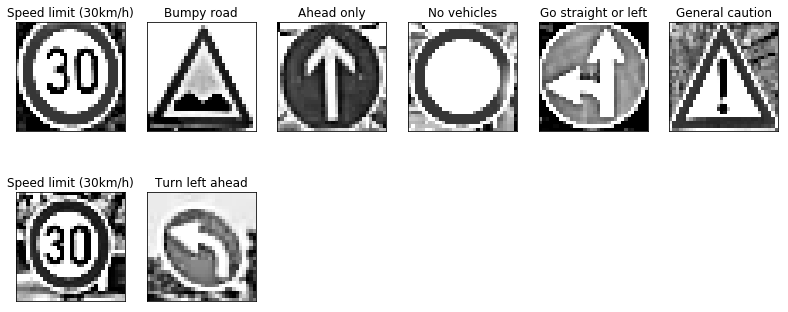

In [186]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

my_images = sorted(glob.glob('./test_images/*.png'))
my_labels = np.array([1, 22, 35, 15, 37, 18, 1, 34])

figures = {}
labels = {}
signs = []
index = 0

#Read the Images 
for my_image in my_images:
    img = cv2.cvtColor(cv2.imread(my_image), cv2.COLOR_BGR2RGB)
    signs.append(img)
    figures[index] = img
    #labels[index] = signs_class[my_labels[index]][1].decode('ascii')
    labels[index] = signs_class[my_labels[index]]
    index += 1

signs_aug = []    

# Do the processing of the images    
for i in range(len(signs)):
        img=signs[i]
        signs_aug.append(transform_img(img))

signs_aug = np.array(signs_aug)

signs = normalize_grayscale(signs_aug)

plot_gallery_color(signs, labels, h, w, 3)

# Do the processing of the images
signs_grey= color.rgb2gray(signs[:])
signs_grey = signs_grey[..., newaxis] # add the new axis which is the channel

plot_gallery_grey(signs_grey, labels, h, w)


### Predict the Sign Type for Each Image

In [187]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    test_accuracy = evaluate(signs_grey, my_labels)
    print()
    test_accuracy_progress.append(test_accuracy)
    print("Test Data Set Accuracy = {:.3f}".format(test_accuracy))

my_single_item_array = []
my_single_item_label_array = []

for i in range(len(my_labels)):
    my_single_item_array.append(signs_grey[i])
    my_single_item_label_array.append(my_labels[i])

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, "./lenet")
        my_accuracy = evaluate(my_single_item_array, my_single_item_label_array)
        print('Image {}'.format(i+1))
        print("Image Accuracy = {:.3f}".format(my_accuracy))
        print()


INFO:tensorflow:Restoring parameters from ./lenet

Test Data Set Accuracy = 1.000
INFO:tensorflow:Restoring parameters from ./lenet
Image 1
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 2
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 3
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 4
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 5
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 6
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 7
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 8
Image Accuracy = 1.000



### Analyze Performance

INFO:tensorflow:Restoring parameters from ./lenet


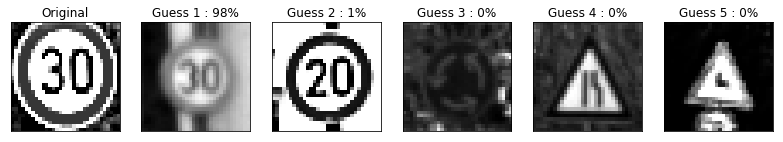

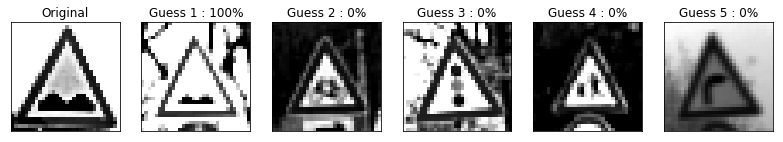

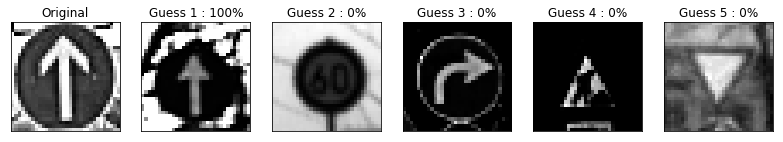

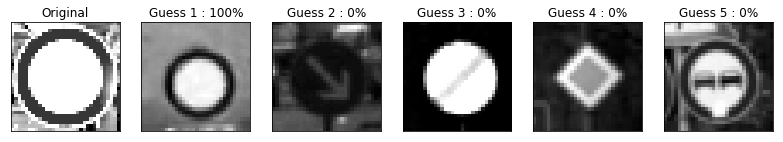

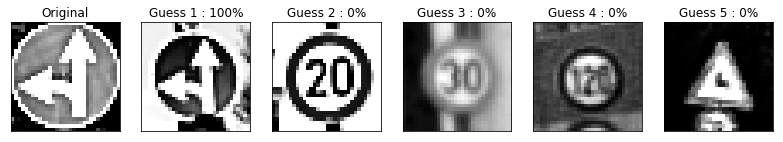

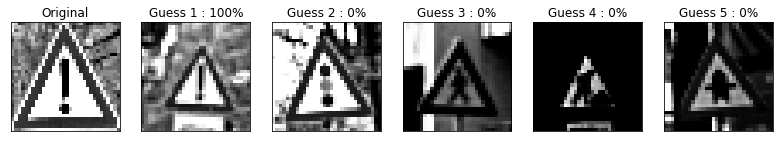

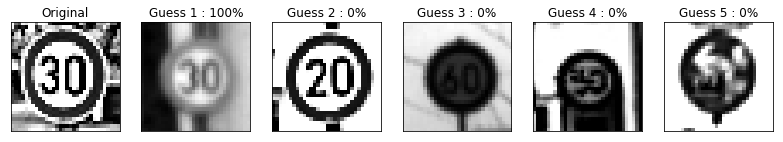

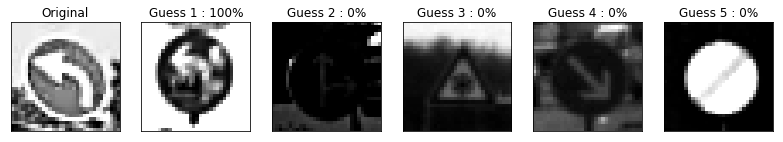

In [188]:
### Calculate the accuracy for these 8 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images

k_size = 5
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=k_size)
#plot_gallery_grey(signs_grey[0][:][:][:], labels, h, w)
testfigures = {}
testlabels = {}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: signs_grey, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: signs_grey, keep_prob: 1.0})

    for i in range(len(my_labels)):
        
        testfigures[0] = signs_grey[i]
        testlabels[0] = "Original"
        
        for j in range(k_size):
            testlabels[j+1] = 'Guess {} : {:.0f}%'.format((j+1), 100*my_top_k[0][i][j])
            testfigures[j+1] = X_valid_grey[np.argwhere(y_valid == my_top_k[1][i][j])[0]].squeeze()

        plot_gallery_grey(testfigures, testlabels, h, w)
 

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

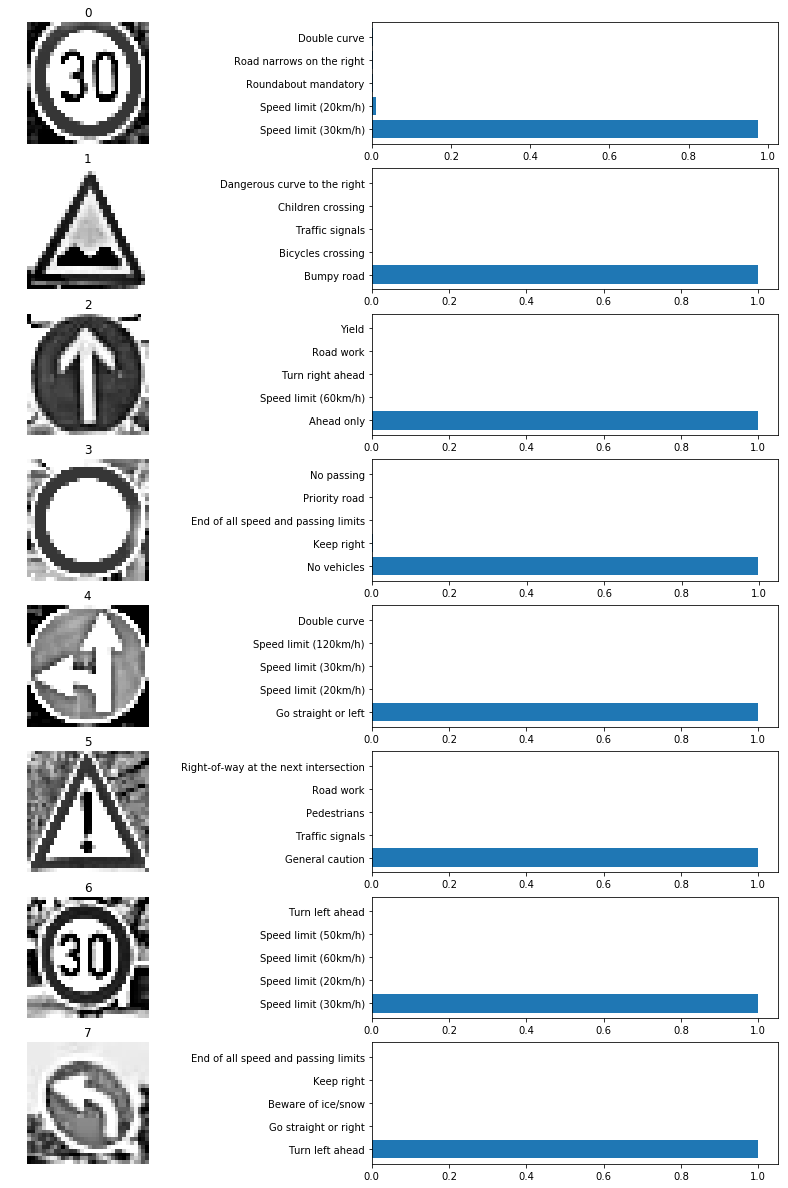

In [189]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

plt.figure(figsize=(16, 21))

for i in range(len(signs_grey)):
    plt.subplot(len(signs_grey), 2, 2*i+1)
    plt.imshow(signs_grey[i].reshape((32, 32)), cmap=plt.cm.gray)
    plt.title(i)
    plt.axis('off')
    plt.subplot(len(signs_grey), 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), my_top_k.values[i, :])
    labs=[signs_class[j] for j in my_top_k.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [190]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,250))
    for featuremap in range(featuremaps):
        plt.subplot(100,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        plt.axis('off')
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")


Input conv shape (?, 32, 32, 1)
Output conv shape (?, 28, 28, 6)
Layer 1 conv1 shape (?, 28, 28, 6)
Layer 1 Max Pool shape (?, 14, 14, 6)
Input conv shape (?, 14, 14, 6)
Output conv shape (?, 10, 10, 16)
Layer 2 conv2 shape (?, 10, 10, 16)
Layer 2 Max Pool shape (?, 5, 5, 16)
Input conv shape (?, 5, 5, 16)
Output conv shape (?, 2, 2, 412)
Layer 3 conv3 shape (?, 2, 2, 412)
Layer 3 Max Pool shape (?, 1, 1, 412)
Flatten Shape (?, 412)
Layer 4 FC Shape (?, 122)
Layer 5 FC Shape (?, 84)
FC Layer6 Shape (?, 43)
INFO:tensorflow:Restoring parameters from ./lenet


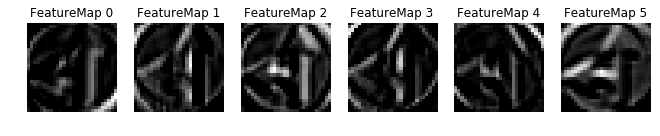

In [197]:
logits, layer1, layer2, layer3, layer4, layer5 = LeNet(x)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')
    outputFeatureMap(my_single_item_array[4:5], layer1)  


Input conv shape (?, 32, 32, 1)
Output conv shape (?, 28, 28, 6)
Layer 1 conv1 shape (?, 28, 28, 6)
Layer 1 Max Pool shape (?, 14, 14, 6)
Input conv shape (?, 14, 14, 6)
Output conv shape (?, 10, 10, 16)
Layer 2 conv2 shape (?, 10, 10, 16)
Layer 2 Max Pool shape (?, 5, 5, 16)
Input conv shape (?, 5, 5, 16)
Output conv shape (?, 2, 2, 412)
Layer 3 conv3 shape (?, 2, 2, 412)
Layer 3 Max Pool shape (?, 1, 1, 412)
Flatten Shape (?, 412)
Layer 4 FC Shape (?, 122)
Layer 5 FC Shape (?, 84)
FC Layer6 Shape (?, 43)
INFO:tensorflow:Restoring parameters from ./lenet


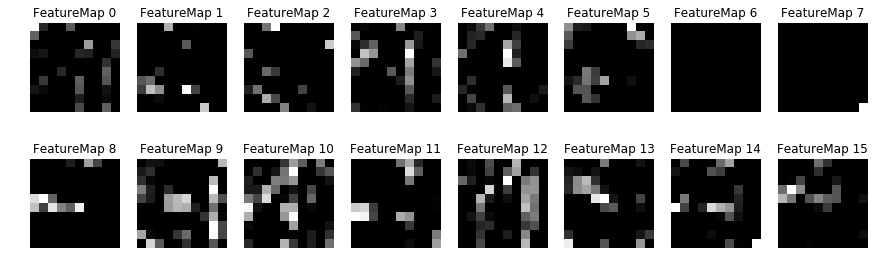

In [198]:
logits, layer1, layer2, layer3, layer4, layer5 = LeNet(x)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')
    outputFeatureMap(my_single_item_array[4:5], layer2)

Input conv shape (?, 32, 32, 1)
Output conv shape (?, 28, 28, 6)
Layer 1 conv1 shape (?, 28, 28, 6)
Layer 1 Max Pool shape (?, 14, 14, 6)
Input conv shape (?, 14, 14, 6)
Output conv shape (?, 10, 10, 16)
Layer 2 conv2 shape (?, 10, 10, 16)
Layer 2 Max Pool shape (?, 5, 5, 16)
Input conv shape (?, 5, 5, 16)
Output conv shape (?, 2, 2, 412)
Layer 3 conv3 shape (?, 2, 2, 412)
Layer 3 Max Pool shape (?, 1, 1, 412)
Flatten Shape (?, 412)
Layer 4 FC Shape (?, 122)
Layer 5 FC Shape (?, 84)
FC Layer6 Shape (?, 43)
INFO:tensorflow:Restoring parameters from ./lenet


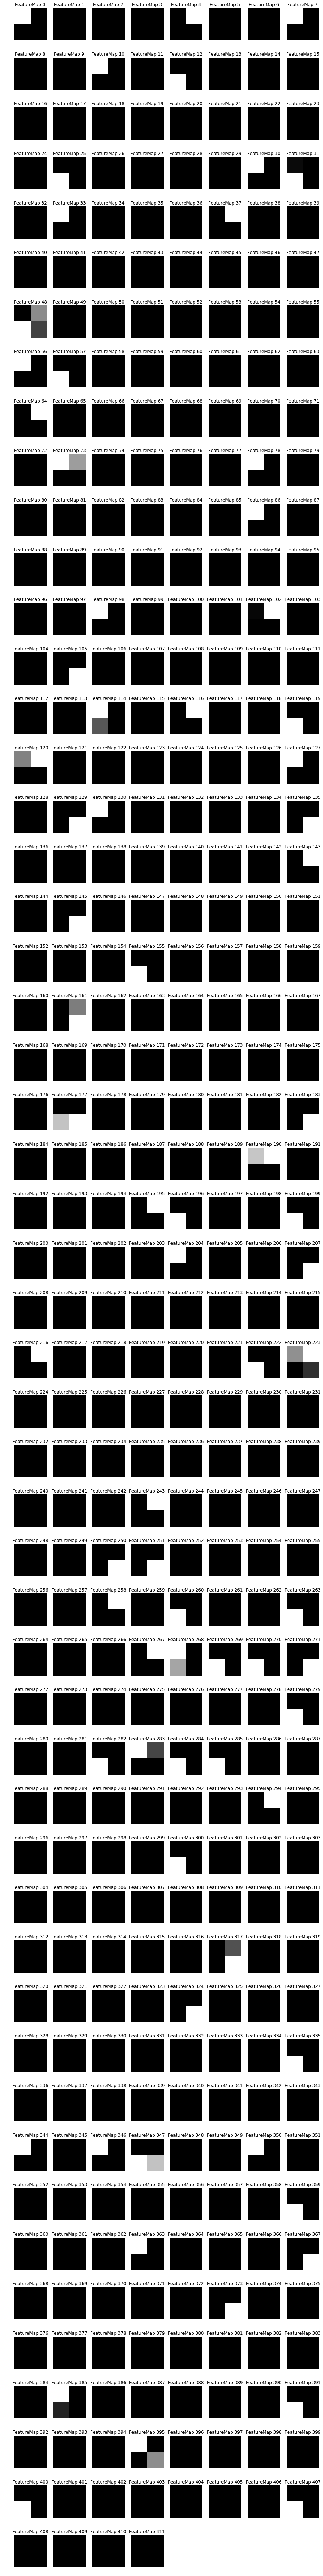

In [199]:
logits, layer1, layer2, layer3, layer4, layer5 = LeNet(x)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './lenet')
    outputFeatureMap(my_single_item_array[4:5], layer3)